# SARIMA Forecasting Model: Quarterly Statewide Beer Production

## Developed for the Washington Brewers Guild by Seattle University's MSDS Program

#### Yen-Ting Chen, Hanisha Karri, McKenzie Maidl, Justus Ngunjiri

### Last Updated: June 2024

In [32]:
# imports
import os
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import font_manager

from statsmodels.tsa.stattools import adfuller

from scipy.stats import boxcox
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

from scipy.special import inv_boxcox
from statsmodels.tsa.arima.model import ARIMA

from sklearn.metrics import mean_squared_error 

import warnings
warnings.filterwarnings('ignore')

### Data

This script takes in quarterly statewide beer production data.

Data was sourced from pages at https://www.ttb.gov/statistics/. Each year, 2015 through 2023 in this case, has its own webpage with a URL in the format statistics/[year]-quarterly-beer-state-statistical-releases. The xlsx for each quarter of each year was downloaded manually and added to a folder with the path 'Data/Forecasting/QuarterlyStateBeerReports/' relative to this script's location.

The script first loops through each of these files and collects the cell with production data for Washington State. It combines these values into a single dataframe used for the rest of the analysis.

In [33]:
# data prep
path = 'Data/Forecasting/QuarterlyStateBeerReports/'
list_dfs=[]
months = {'Q1': '01', 'Q2': '04', 'Q3': '07', 'Q4': '10'}
for file in os.listdir(path):
    if '~$' not in file:
        # get file
        filename = path + file
        df = pd.read_excel(filename)
        
        # only take Washington record
        df = pd.DataFrame(df[df.iloc[:, 0] == 'Washington'].iloc[:,1])
        
        # get date time
        year = file[:4]
        quarter = file[5:7]
        df['quarter'] = year + quarter
        
        list_dfs.append(df)

# concat data
prod = pd.concat(list_dfs)

# clean up data
prod.rename(columns={'Unnamed: 1': 'production'}, inplace=True)
prod['quarter'] = pd.to_datetime(prod['quarter'], format='mixed')
prod.sort_values(by='quarter', inplace=True)
prod.reset_index(drop=True, inplace=True)
prod = prod[['quarter', 'production']]

# change column types
prod['production'].replace(',','', regex=True, inplace=True)
prod['production'] = pd.to_numeric(prod['production'])

# save data
prod.to_excel('Data/Forecasting/quarterly_beer_reports.xlsx')

In [34]:
# view data
prod.head(10)

,quarter,production
0,2015-01-01,138240.44
1,2015-04-01,151231.15
2,2015-07-01,161505.20
3,2015-10-01,135659.54
4,2016-01-01,144673.26
5,2016-04-01,164690.01
6,2016-07-01,159577.78
7,2016-10-01,130911.14
8,2017-01-01,129666.67
9,2017-04-01,154792.88


In [35]:
# data info
prod.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35 entries, 0 to 34
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   quarter     35 non-null     datetime64[ns]
 1   production  35 non-null     float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 692.0 bytes


In [36]:
# visualization settings

# use lato font
font_path = 'Reference/Lato/Lato-Regular.ttf'
font_manager.fontManager.addfont(font_path)
prop = font_manager.FontProperties(fname=font_path)
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = prop.get_name()

# set colors
col_yellow = '#ffa400'
col_green = '#256143'
col_brown = '#9c5421'
col_off_black = '#434343'
mpl.rcParams['text.color'] = col_off_black # title and legend
mpl.rcParams['xtick.color'] = col_off_black # tick marks
mpl.rcParams['ytick.color'] = col_off_black # tick marks
mpl.rcParams['axes.labelcolor'] = col_off_black # axes labels

# set font sizes
mpl.rcParams['axes.titlesize'] = 14 # title
mpl.rcParams['axes.labelsize'] = 12 # axes labels
mpl.rcParams['xtick.labelsize'] = 11 # tick marks
mpl.rcParams['ytick.labelsize'] = 11 # tick marks
mpl.rcParams['legend.title_fontsize'] = 12 # legend title
mpl.rcParams['legend.fontsize'] = 11 # legend text

# set figure size
figsz = (10,6)

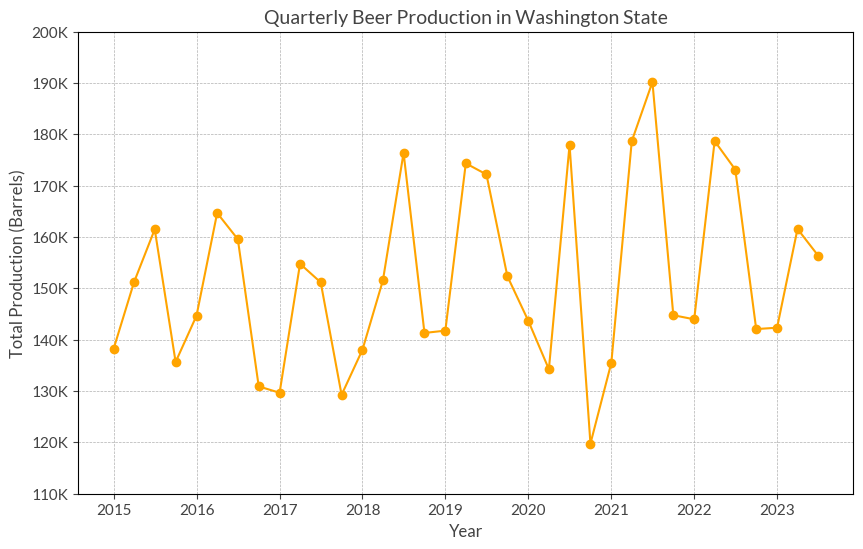

In [37]:
# plot time series
def plot_time_series(df: pd.DataFrame, y: str, y_label: str, adjust_y_labels: bool):
    # general function to plot timeseries data
    
    plt.figure(figsize=figsz)

    plt.plot(df['quarter'], df[y], color=col_yellow, marker='o')

    plt.title('Quarterly Beer Production in Washington State')
    plt.xlabel('Year')
    plt.ylabel(y_label)

    if adjust_y_labels == True:
        ylocs, ylabels = plt.yticks() 
        ylabels_new = ['{:,.0f}'.format(x) + 'K' for x in ylocs/1000]
        plt.yticks(ylocs, ylabels_new)

    plt.grid(axis='y', linestyle='--', linewidth=0.5)
    plt.grid(axis='x', linestyle='--', linewidth=0.5)

plot_time_series(df=prod, y='production', y_label='Total Production (Barrels)',
                adjust_y_labels=True)

**Augmented Dickey-Fuller Test**

A unit root test determines how strongly a time series is defined by a trend. We can use the Augmented Dickey-Fuller Test to test for unit root.

Null Hypothesis (H0): The time series can be represented by a unit root or is not stationary, meaning it has some time-dependent structure.

Alternate Hypothesis (H1): The time series does not have a unit root, meaning it is stationary and does not have time-dependent structure.

If we reject the null, then we can conclude that the time series is stationary, which is required for forecasting.

In [38]:
# test if data is stationary: Augmented Dickey-Fuller Test
def run_adf(x):   
    # run test
    adft = adfuller(x)

    # results
    test_stat = adft[0]
    p_val = adft[1]
    critical_vals = adft[4].items()
    lang, run_boxcox = ('', 0) if p_val < 0.05 else ('not', 1)

    # print results
    print('ADF Test Statistic: %f' % test_stat)
    print('p-value: %f' % p_val)
    print('Critical Values:')
    for key, value in critical_vals:
        print('\t%s: %.3f' % (key, value))
    print(f'We can{lang} reject the Null Hypothesis and can{lang} conclude that the time series is stationary.')
    
    return run_boxcox

run_boxcox = run_adf(prod['production'])

ADF Test Statistic: -2.603283
p-value: 0.092321
Critical Values:
	1%: -3.679
	5%: -2.968
	10%: -2.623
We cannot reject the Null Hypothesis and cannot conclude that the time series is stationary.


**Box-Cox Transformation**

If the data is not stationary, then we must transform it to make it stationary. To do this we will use the Box-Cox transformation. This technique is a generalization of the logarithmic transformation, where the variable x is transformed to log(x). The effect of this is to make data follow a normal distribution and ultimately stationary.

ADF Test Statistic: -3.109144
p-value: 0.025884
Critical Values:
	1%: -3.753
	5%: -2.998
	10%: -2.639
We can reject the Null Hypothesis and can conclude that the time series is stationary.


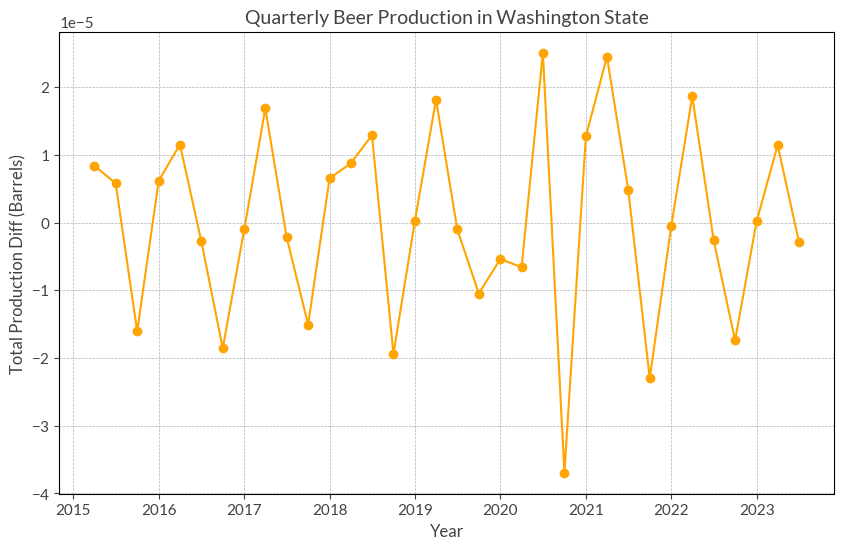

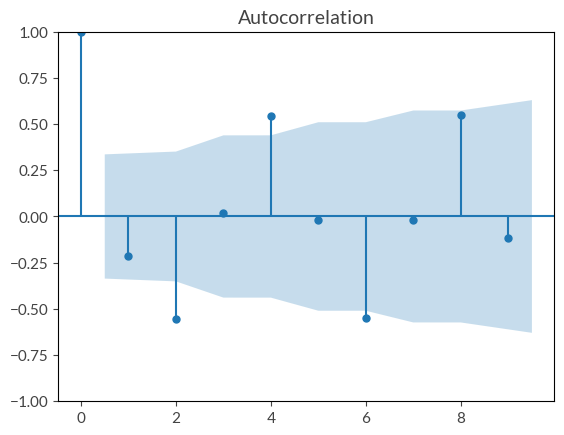

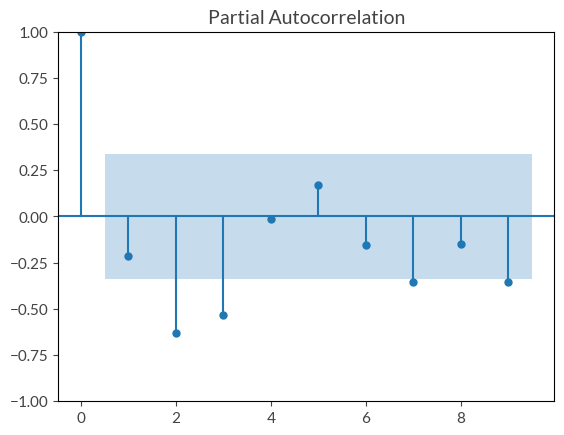

In [39]:
# make data stationary if required
if run_boxcox == 1:
    # Box-Cox Transformation
    prod['production_boxcox'],lam = boxcox(prod['production'])
    prod['production_diff'] = prod['production_boxcox'].diff()
    prod.dropna(inplace=True)
    
    # re-run Augmented Dickey-Fuller
    run_adf(prod['production_diff'])

    # plot stationary data
    plot_time_series(df=prod, y='production_diff', y_label='Total Production Diff (Barrels)',
                    adjust_y_labels=False)
    
    # plot ACF and PACF
    plot_acf(prod['production_diff'], lags=9)
    plot_pacf(prod['production_diff'], method='ywm', lags=9)
    plt.show()
    
    # variable to use for analysis
    model_var = 'production_boxcox'

else:
    # plot ACF and PACF
    plot_acf(prod['production'], lags=9)
    plot_pacf(prod['production'], method='ywm', lags=9)
    plt.show()
    
    # variable to use for analysis
    model_var = 'production'  

**Developing the Model**

Different models should be tested. The components of the SARIMA to be tested: ARIMA(p,d,q)(P,D,Q)m

Non-Seasonal Components
- p: autoregressive
- d: difference
- q: moving average

Seasonal Components
- P: seasonal autoregressive
- D: seasonal difference
- Q: seasonal moving average
- m: number of time steps for a single seasonal period.

The lags are also significant around the second lag for both plots. A seasonal value of 2 or 4 may be suitable. A value of 4 would indicate annual trend with quarterly data.

In [40]:
# train and test set 
prod.index = pd.to_datetime(prod['quarter'])
prod.index = prod.index.to_period('Q')
train = prod.iloc[:-int(len(prod) * 0.2)]
test = prod.iloc[-int(len(prod) * 0.2):]

In [41]:
# test different models (original or transformed)
pqtest = [0,1,2,3,4]
mtest = [2,4]

labels = []
pvals = []
qvals = []
psvals = []
qsvals = []
mvals = []
aic = []
bic = []

for p in pqtest:
    for q in pqtest:
        for ps in pqtest:
            for qs in pqtest:
                for m in mtest:
                    if p < m and q < m and (p != 0 and q != 0) and (ps != 0 and qs != 0):
                        model = ARIMA(train[model_var], order=(p,0,q), seasonal_order=(ps,0,qs,m)).fit()
                        labels.append('SARIMA({},0,{})({},0,{},{})'.format(p,q,ps,qs,m))
                        pvals.append(p)
                        qvals.append(q)
                        psvals.append(ps)
                        qsvals.append(qs)
                        mvals.append(m)
                        aic.append(model.aic)
                        bic.append(model.bic)
            
model_results = pd.DataFrame(
    {'model': labels,
     'p': pvals,
     'q': qvals,
     'P': psvals,
     'Q': qsvals,
     'm': mvals,
     'aic': aic,
     'bic': bic
    })

model_results = model_results.sort_values(by='aic').reset_index(drop=True)
model_results

,model,p,q,P,Q,m,aic,bic
0,"SARIMA(1,0,1)(3,0,1,2)",1,1,3,1,2,-555.312296,-544.654660
1,"SARIMA(1,0,1)(2,0,1,4)",1,1,2,1,4,-554.384838,-545.059406
2,"SARIMA(1,0,2)(1,0,2,4)",1,2,1,2,4,-553.544825,-542.887189
3,"SARIMA(1,0,1)(1,0,2,4)",1,1,1,2,4,-553.437710,-544.112278
4,"SARIMA(1,0,1)(1,0,2,2)",1,1,1,2,2,-553.199662,-543.874230
...,...,...,...,...,...,...,...,...
155,"SARIMA(3,0,3)(4,0,2,4)",3,3,4,2,4,-480.688423,-462.037560
156,"SARIMA(3,0,3)(2,0,4,4)",3,3,2,4,4,-480.688423,-462.037560
157,"SARIMA(3,0,3)(3,0,4,4)",3,3,3,4,4,-478.688423,-458.705356
158,"SARIMA(3,0,3)(4,0,3,4)",3,3,4,3,4,-478.688423,-458.705356


In [42]:
# best model (lowest AIC, BIC)
model = model_results.loc[0,'model']
p = model_results.loc[0,'p']
q = model_results.loc[0,'q']
m = model_results.loc[0,'m']

print(f'The best model is a {model}.')

model = ARIMA(train[model_var], order=(p,1,q), seasonal_order=(1,1,1,m)).fit()

The best model is a SARIMA(1,0,1)(3,0,1,2).


In [43]:
# 5-year forecast
forecast_len = len(test) + 21 # quarterly data * 5 years after test data (end at end of year)
if run_boxcox == 1:
    boxcox_forecasts = model.forecast(forecast_len)
    forecasts = inv_boxcox(boxcox_forecasts, lam) # reverse back to original production values
    forecast_info = model.get_forecast(forecast_len).conf_int(alpha=0.05)
    lower = inv_boxcox(forecast_info['lower production_boxcox'], lam)
    upper = inv_boxcox(forecast_info['upper production_boxcox'], lam)
    conf_int = pd.DataFrame({'lower production_boxcox':lower, 'upper production_boxcox':upper})
    
else:
    forecasts = model.forecast(forecast_len)
    conf_int = model.get_forecast(forecast_len)
    
# get length of forecasts for plotting
forecasts_test = forecasts[0:len(test)]

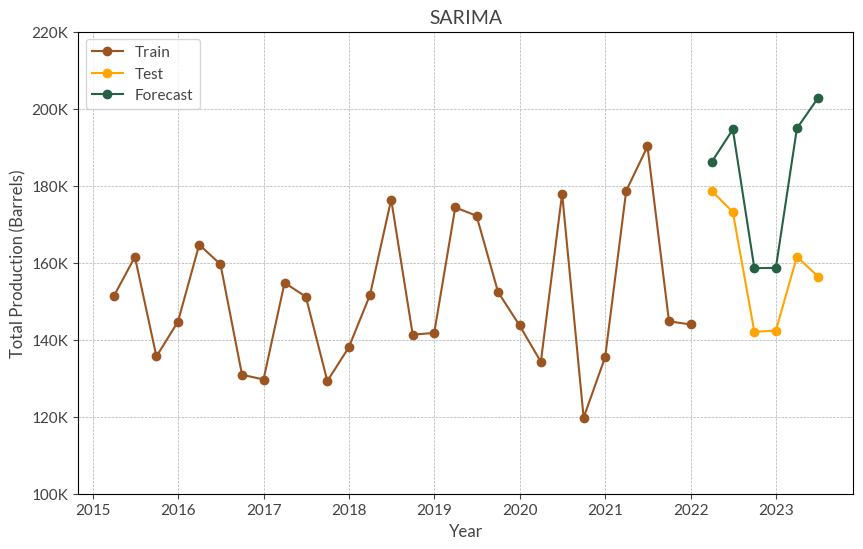

In [44]:
# plot forecasts
plt.figure(figsize=figsz)

plt.plot(train['quarter'], train['production'], color=col_brown, marker='o', label='Train')
plt.plot(test['quarter'], test['production'], color=col_yellow, marker='o', label='Test')
plt.plot(test['quarter'], forecasts_test, color=col_green, marker='o', label='Forecast')

plt.title('SARIMA')
plt.xlabel('Year')
plt.ylabel('Total Production (Barrels)')
plt.legend()

ylocs, ylabels = plt.yticks() 
ylabels_new = ['{:,.0f}'.format(x) + 'K' for x in ylocs/1000]
plt.yticks(ylocs, ylabels_new)

plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.grid(axis='x', linestyle='--', linewidth=0.5)

In [45]:
# MSE
observed = test['production']
predicted = forecasts_test
mean_squared_error(observed, predicted) 

720578479.8177925

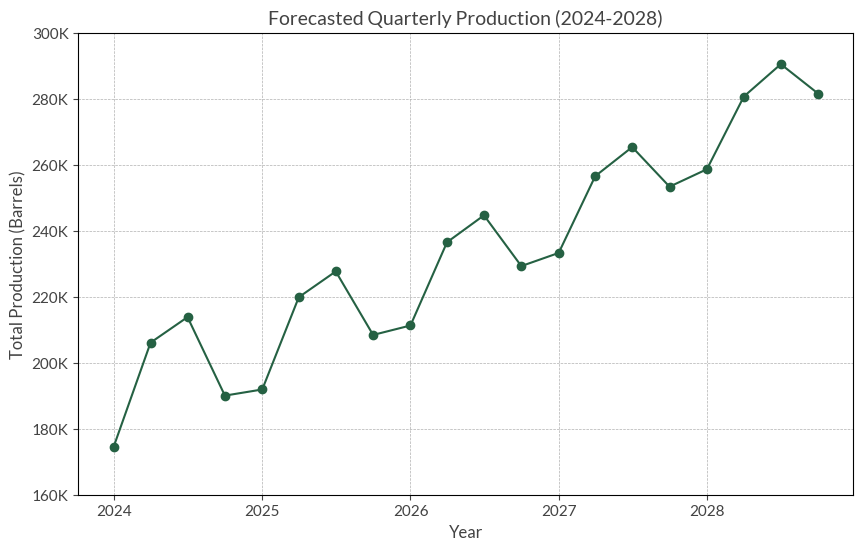

In [46]:
# plot future forecasts
plt.figure(figsize=figsz)

data = forecasts[7:].reset_index()
data['index'] = data['index'].dt.to_timestamp('s').dt.strftime('%Y-%m-%d')
data['index'] = pd.to_datetime(data['index'])

plt.plot(data['index'], data['predicted_mean'], color=col_green, marker='o')

plt.title('Forecasted Quarterly Production (2024-2028)')
plt.xlabel('Year')
plt.ylabel('Total Production (Barrels)')

ylocs, ylabels = plt.yticks() 
ylabels_new = ['{:,.0f}'.format(x) + 'K' for x in ylocs/1000]
plt.yticks(ylocs, ylabels_new)

plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.grid(axis='x', linestyle='--', linewidth=0.5)